In [1]:
%matplotlib inline

In [2]:
!hostname

mum-hpc2-gpu4


In [3]:
%cd ICRA_2023

/home/ssap0002/ICRA_2023


In [4]:
from VRNN_DAT import VRNN_DAT
from RNN import GRU, LSTM
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

2023-02-28 16:08:57.436421: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Data Loading

In [5]:
import os
import numpy as np
import pickle5 as pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

ORI_DATA_DIR = 'data/gripper/full'
HALF_DATA_DIR = 'data/gripper/half'
SYNTH_DATA_DIR = 'output/'

In [6]:
def to_timeseries(X, y, time_steps = 50):
    dataX = []
    dataY = []
    # Cut data by sequence length
    for i in range(0, len(X) - time_steps):
        _x = X[i:i+time_steps, :]
        _y = y[i:i+time_steps, :]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

def revert_timeseries(X, time_steps = 100):
  # if len(X[0]) == time_steps and time_steps != 1:
  #   return np.array(X[0])
  head = X[0]
  tail = np.array([f[time_steps-1] for f in X])
  return np.concatenate((head, tail))

def load_pickle(filepath):
    with open(filepath,'rb') as f:
      x = pickle.load(f)
      return x
    
def _preprocess(data):
  # Features
  flex = data['Flex'][0]
  pressure = data['Pressure'][0]

  # Labels
  f1, f2 = data['Force']
  x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = data['PosX']
  y1, y2, y3, y4, y5, y6, y7, y8, y9, y10 = data['PosY']
      
  x = list(zip(flex, pressure, f1, f2, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10))
  return np.array(x)

def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def load_data(s, _from='Train', scaler=None):
  raw_data = load_pickle("data/new_soro_all.pkl")
  train = raw_data.xs(_from, axis=0, level=1, drop_level=True)

  raw_data = _preprocess(train[s])

  # Normalize 
  if scaler is None:
      label_scaler = MinMaxScaler(clip=True)
      feature_scaler = MinMaxScaler(clip=True)
    
      features, labels = feature_scaler.fit_transform(raw_data[:, :2]), label_scaler.fit_transform(raw_data[:, 2:])
      print(f"creating scaler from {s}")
      
  else:
    print("reusing scaler")
    label_scaler, feature_scaler = scaler
    features, labels = feature_scaler.transform(raw_data[:, :2]), label_scaler.transform(raw_data[:, 2:])
    

  # Timeseries
  X_train, y_train = to_timeseries(features, labels, params['timesteps'])

  return  X_train, y_train, (label_scaler, feature_scaler)      

In [7]:
def load_dataset(datatype, datasets, batch_size, no_state_data=[], scaler=None):
    X_train, y_train, domain_labels, scenario_name = [], [], [], []
    
    if datatype == 'test':
        for scenario in datasets:
            _x, _y, scaler = load_data(scenario, _from='Test', scaler=scaler)
            X_train.append(np.array(_x).astype('float32')), y_train.append(np.array(_y).astype('float32'))
            scenario_name.append([scenario for _ in range(len(_x))])
            if scenario in no_state_data:
                domain_labels.append([0 for _ in range(len(_x))])
            else:
                domain_labels.append([1 for _ in range(len(_x))])

        for i, (x,y) in enumerate(zip(X_train, y_train)):
            if i == 0:
                dataset = tf.data.Dataset.from_tensor_slices((x, y, domain_labels[i], scenario_name[i]))
                dataset = dataset.shuffle(len(x)).take(1000).batch(batch_size)
                # dataset = dataset.batch(batch_size)
                
            
            else: 
                _d = tf.data.Dataset.from_tensor_slices((x, y, domain_labels[i], scenario_name[i]))
                _d = _d.shuffle(len(x)).take(1000).batch(batch_size)
                # _d = _d.batch(batch_size)
                
                dataset = dataset.concatenate(_d)
        return dataset, scaler
    
    elif datatype == 'train':
        for scenario in datasets:
            _x, _y, scaler = load_data(scenario, _from='Train', scaler=scaler)
            X_train.append(np.array(_x).astype('float32')), y_train.append(np.array(_y).astype('float32'))
            if scenario in no_state_data:
                domain_labels.append([0 for _ in range(len(_x))])
            else:
                domain_labels.append([1 for _ in range(len(_x))])

        Xdata = np.concatenate(X_train)
        ydata = np.concatenate(y_train)
        Statedata = np.concatenate(domain_labels).astype(np.float32)

        # Shuffle
        p = np.random.permutation(len(Xdata))
        Xdata = Xdata[p]
        ydata = ydata[p]
        Statedata = Statedata[p]

        dataset =  tf.data.Dataset.from_tensor_slices((Xdata ,ydata, Statedata))
        return dataset.batch(batch_size), scaler

In [8]:
def get_dataset(model_type, train_scenario, batch_size):
    
    if train_scenario == "tip_contact":        
        all_datasets = ['osc_tip_30', 'osc_rand_30', 'rand_tip_30', 'rand_rand_60']
    elif train_scenario == "random_contact":
        all_datasets = ['osc_rand_30', 'rand_rand_60','osc_tip_30', 'rand_tip_30']
        
    if train_scenario == "tip_contact":
        _train_d = ['osc_tip_30', 'rand_tip_30']
    elif train_scenario == "random_contact":
        _train_d = ['osc_rand_30', 'rand_rand_60']
    
    # _test_d = [d for d in all_datasets if d not in _train_d]
    _test_d = [d for d in all_datasets]
    
        
    if model_type == "GRU" or model_type == "LSTM":           
        train_dataset, scaler = load_dataset('train', _train_d, batch_size)
    
    elif "VRNN_DAT" in model_type:
        train_dataset, scaler = load_dataset('train', all_datasets, batch_size, no_state_data=[d for d in all_datasets if d not in _train_d])
        
    test_dataset, _ = load_dataset('test', _test_d, batch_size, scaler=scaler, no_state_data=[d for d in all_datasets if d not in _train_d])
    
    return train_dataset, test_dataset, scaler

def get_model(model_type, params=None):
    if model_type == "GRU":
        return GRU(params['x_dim'], params['timesteps'], params['z_dim'], params['h_dim'])
    elif model_type == "LSTM":
        return LSTM(params['x_dim'], params['timesteps'], params['z_dim'], params['h_dim'])
    elif model_type == "VRNN":
        pass
    elif "VRNN_DAT" in model_type:
        return VRNN_DAT(params['x_dim'], params['h_dim'], params['z_dim'], phi_x_dim=params['phi_x_dim'], d_dim=params['d_dim'], vrnn_lr=params['lr'], adv_lr=params['adv_lr'], clip=params['clip'], rnn=params['rnn'])

## Hyperparameters

In [9]:
x_dim = 2 # flex + pressure
h_dim = 128
z_dim = 22 # 2 force + 10*2D coordinates
phi_x_dim = 32
d_dim = 128
n_epochs = 50
clip = 5
lr = 1e-3
adv_lr = 1e-3
batch_size = 128 # 32
seed = 261199
timesteps=100
rnn="GRU"
# tf.random.set_seed(seed)

In [10]:
from sorcery import dict_of

params = dict_of(x_dim, h_dim, z_dim, phi_x_dim, timesteps, d_dim, n_epochs, clip, lr, adv_lr, batch_size, rnn)

## Load Models

In [11]:
def load_model(model_type, train_scenario, run=3):
    print(f"================={model_type}:{train_scenario}:{run}==================")
    # Prepare dataset and model
    if model_type == "VRNN_DAT_GRU":
        params['rnn'] = 'GRU'
    elif model_type == "VRNN_DAT_LSTM":
        params['rnn'] = 'LSTM'
        
    train_dataset, test_dataset, scalers = get_dataset(model_type, train_scenario, params['batch_size'])
    model = get_model(model_type, params)

    # Train
    if model_type == "GRU" or model_type == "LSTM":
        model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.RootMeanSquaredError()])
    else:
        model.compile()

    # Save weights
    model.load_weights(f"weights/one_scaler/dat_z/{model_type}/{train_scenario}/run_{run}/")
    print("loaded model")    
    return model

def get_estimated_state(model, test_dataset, return_phi_z=False):
    pred = []
    for step, (x_batch_test, y_batch_test, _, _) in enumerate(test_dataset):
        _pred = model.predict(x_batch_test, return_phi_z=return_phi_z)
        pred.append(_pred)
        
    pred = np.concatenate(pred)
    return pred

def get_latent_measurement(model, test_dataset):
    pred, y_test = [], []
    for step, (x_batch_test, y_batch_test, _, _) in enumerate(test_dataset):
        _pred = model.get_feature_representation(x_batch_test)
        pred.append(_pred)
        y_test.append(y_batch_test)
        
    pred = np.concatenate(pred)
    return pred


## TSNE

In [12]:
train_scenario = 'tip_contact'

vrnn_dat = load_model('VRNN_DAT_LSTM', train_scenario, 1)
rnn = load_model("LSTM", train_scenario, 1)

=================VRNN_DAT_LSTM:tip_contact:1==================
creating scaler from osc_tip_30
reusing scaler
reusing scaler
reusing scaler


2023-02-28 16:09:04.698406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 16:09:07.032189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18131 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 2g.20gb, pci bus id: 0000:65:00.0, compute capability: 8.0


reusing scaler
reusing scaler
reusing scaler
reusing scaler
DAT on Zt
Using LSTM Backend
loaded model
=================LSTM:tip_contact:1==================
creating scaler from osc_tip_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
loaded model


In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [14]:
train_dataset, test_dataset, scalers = get_dataset("GRU", train_scenario, params['batch_size'])

creating scaler from osc_tip_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler


In [15]:
y_data, labels, scenario_names = [], [], []
for i, (x,y,state, scenarios) in enumerate(test_dataset.as_numpy_iterator()):
    y_data.append(y)
    labels.append(state)
    scenario_names.append(scenarios)
    
y_data = np.array(y_data)
labels = np.concatenate(labels)
scenario_names = np.concatenate(scenario_names)

/tmp/ipykernel_48138/1997918807.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_data = np.array(y_data)


In [16]:
y_data.shape, labels.shape, scenario_names.shape

((32,), (4000,), (4000,))

In [17]:
# plt.plot(y_data[:, 0])
# labels

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [19]:
def plot_tsne(encoded_features, labels, names):
  tsne = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=1000)
  tsne_results = tsne.fit_transform(encoded_features)

  data_df = pd.DataFrame(tsne_results, columns=['x', 'y'])
  data_df['domain'] = labels
  data_df['scenario'] = names
  data_df['sizes'] = [5 for _ in range(len(names))]

  return data_df

def plot_pca(encoded_features, labels, names):
  pca = PCA(n_components=2)
  pca_results = pca.fit_transform(encoded_features)
  
  data_df = pd.DataFrame(pca_results, columns=['x', 'y'])
  data_df['domain'] = labels
  data_df['scenario'] = names
  data_df['sizes'] = [5 for _ in range(len(names))]

  return data_df

(4000, 22)


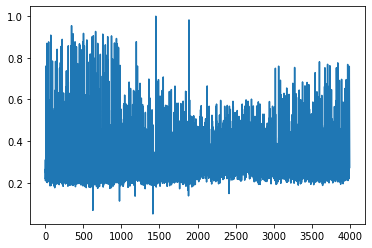

(4000, 22)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.000s...
[t-SNE] Computed neighbors for 4000 samples in 0.285s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.077664


/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.548470
[t-SNE] KL divergence after 1000 iterations: 0.405547


In [20]:
# y = scalers[0].inverse_transform(revert_timeseries(np.concatenate(y_data), 100))[100:]
y = revert_timeseries(np.concatenate(y_data), 100)[100:]

print(y.shape)
plt.plot(y[:, 0])
plt.show()
# y = revert_timeseries(np.concatenate(y_data))[100:]

print(y.shape)
df = plot_tsne(y, labels, scenario_names)
# df_pca = plot_pca(y, labels, scenario_names)

In [21]:
# # vrnn_dat_latent = get_latent_measurement(vrnn_dat, test_dataset)[:, -1, :]
# vrnn_dat_latent = revert_timeseries(get_latent_measurement(vrnn_dat, test_dataset))[100:]

# print(vrnn_dat_latent.shape)
# vrnn_dat_latent_df = plot_tsne(vrnn_dat_latent, labels, scenario_names)
# # vrnn_dat_latent_df_pca = plot_pca(vrnn_dat_latent, labels, scenario_names)

In [22]:
# # rnn_pred = get_estimated_state(rnn, test_dataset)[:, -1, :]
# rnn_pred = scalers[0].inverse_transform(revert_timeseries(get_estimated_state(rnn, test_dataset)))[100:]
# print(rnn_pred.shape)
# rnn_df = plot_tsne(rnn_pred, labels, scenario_names)

In [23]:
# vrnn_dat_pred = get_estimated_state(vrnn_dat, test_dataset)[:, -1, :]
vrnn_dat_pred = revert_timeseries(get_estimated_state(vrnn_dat, test_dataset, False))[100:]
vrnn_dat_pred_features = revert_timeseries(get_latent_measurement(vrnn_dat, test_dataset))[100:]
print(vrnn_dat_pred.shape)
vrnn_dat_df = plot_tsne(vrnn_dat_pred, labels, scenario_names)
vrnn_dat_features_df = plot_tsne(vrnn_dat_pred_features, labels, scenario_names)

2023-02-28 16:09:30.667964: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-28 16:09:30.969409: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


(4000, 22)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.000s...
[t-SNE] Computed neighbors for 4000 samples in 0.297s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.048151


/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.067001
[t-SNE] KL divergence after 1000 iterations: 0.502978
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.000s...
[t-SNE] Computed neighbors for 4000 samples in 0.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.033091


/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.183357
[t-SNE] KL divergence after 1000 iterations: 0.441159


In [24]:
ndf = df.copy()
dsvb_df = vrnn_dat_features_df.copy()

def to_labels(string):
  if string == 'osc_rand_30':
    return 'Osc. Surface Contact'
  elif string == 'osc_tip_30':
    return 'Osc. Tip Contact'
  if string == 'rand_rand_60':
    return 'Rand. Surface Contact'
  if string == 'rand_tip_30':
    return 'Rand. Tip Contact'

ndf['domain'] = df['domain'].transform(lambda x : 'Source' if int(x) == 1 else 'Target')
ndf['scenario'] = np.vectorize(to_labels)(df['scenario'].str.decode("utf-8"))

dsvb_df['domain'] = vrnn_dat_df['domain'].transform(lambda x : 'Source' if x == 1 else 'Target')
dsvb_df['scenario'] = np.vectorize(to_labels)(vrnn_dat_df['scenario'].str.decode("utf-8"))

ndf['Domain']  = ndf['domain']
ndf['Scenario'] = ndf['scenario']

dsvb_df['Domain']  = dsvb_df['domain']
dsvb_df['Scenario'] = dsvb_df['scenario']


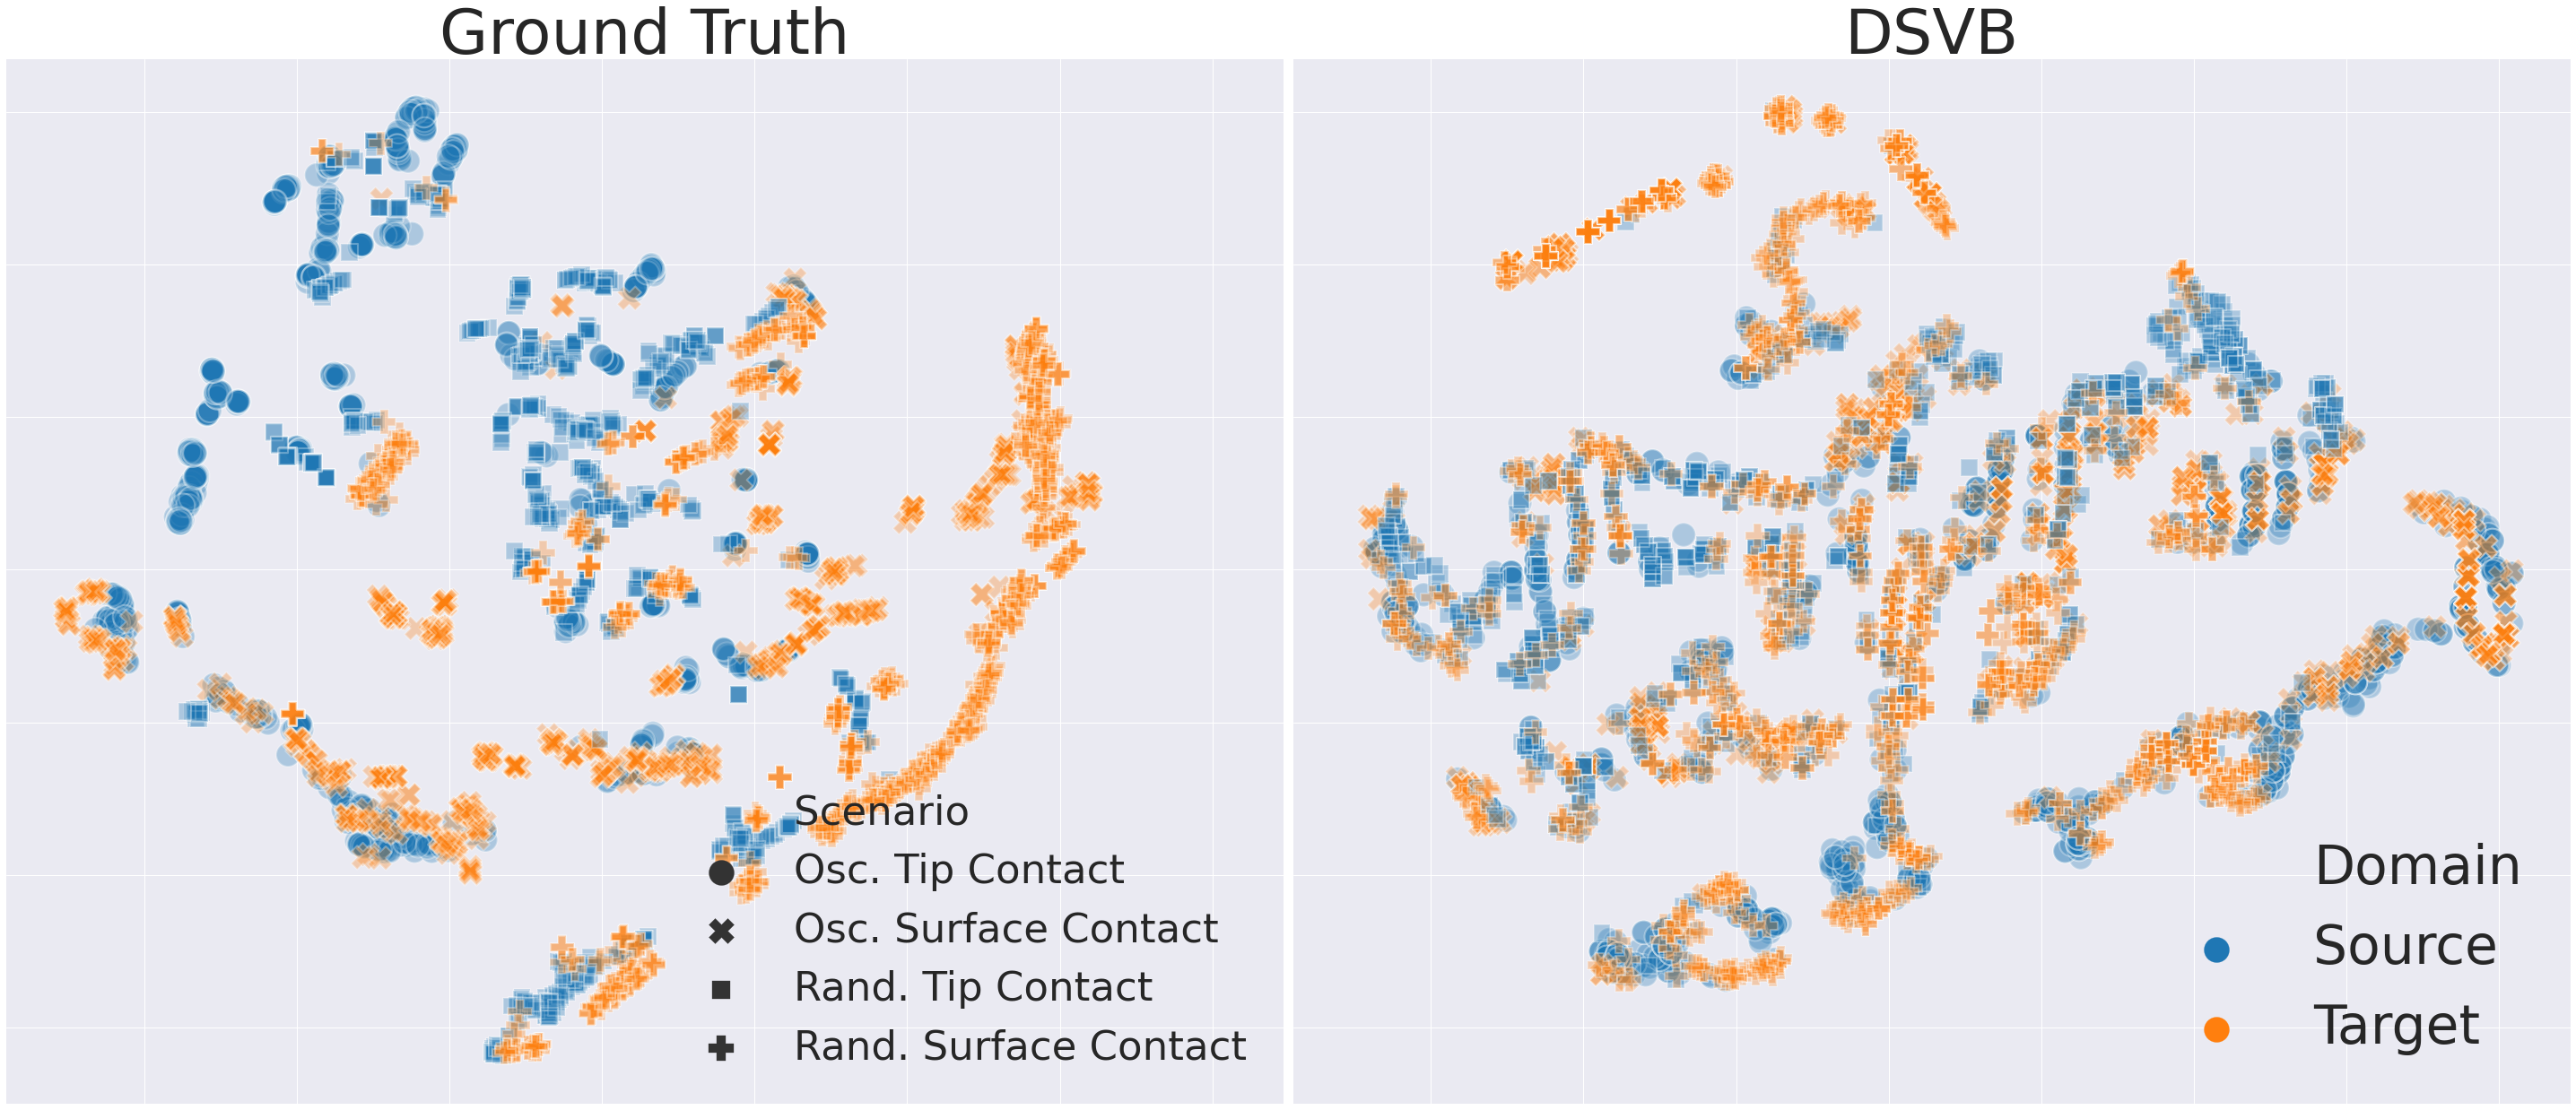

In [32]:
titleSize = 70; subtitleSize = 40; labelSize = 40; tickSize = 30; legendSize = 45
plt.style.use('seaborn')
f, (a1, a2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(40, 30))
# f, (a1, a2, a3) = plt.subplots(1,3, figsize=(20, 10))

     # fontsize of the axes title
marker_size=700

a1.title.set_text("Ground Truth")
a1 = sns.scatterplot(
x="x", y="y",
hue="Domain",
style="Scenario",
palette=sns.color_palette("tab10", len(ndf['Domain'].unique())),
data=ndf,
alpha=0.3,
ax=a1,
s=marker_size,
)
#For Legend
h,l = a1.get_legend_handles_labels()
# l1 = a1.legend(h[:3],l[:3], loc='upper left', fontsize=legendSize, markerscale=2)
l2 = a1.legend(h[3:],l[3:], loc='lower right', fontsize=legendSize, markerscale=4)
# l1 = a1.legend(h[:3],l[:3], loc='lower right', fontsize=legendSize, markerscale=4)



a2.title.set_text("DSVB")

a2 = sns.scatterplot(
x="x", y="y",
hue="Domain",
style="Scenario",
palette=sns.color_palette("tab10", len(dsvb_df['Domain'].unique())),
data=dsvb_df,
alpha=0.3,
ax=a2,
s=marker_size
)

# a1.legend(loc='lower right', fontsize='23', title_fontsize='60', shadow=True, markerscale=2)
# a2.legend(loc='lower right', fontsize='20', title_fontsize='60', shadow=True, markerscale=3)
#For Legend
h,l = a2.get_legend_handles_labels()
l1 = a2.legend(h[:3],l[:3], loc='lower right', fontsize=60, markerscale=4)
# l2 = a2.legend(h[3:],l[3:], loc='lower right', fontsize=legendSize, markerscale=4)


a1.set_aspect('equal', adjustable='box')
a2.set_aspect('equal', adjustable='box')

a1.tick_params(left = False, labelleft = False, bottom=False,labelbottom=False, axis='both', labelsize=tickSize)
a2.tick_params(left = False, labelleft = False, bottom=False,labelbottom=False, axis='both', labelsize=tickSize)
a1.set_ylabel("")
a1.set_xlabel("")
a2.set_xlabel("")

a1.title.set_size(titleSize)
a2.title.set_size(titleSize)
f.tight_layout()


# a3.set_aspect('equal', adjustable='box')
plt.savefig("tsne", dpi=600, bbox_inches = 'tight', pad_inches = 0)
